In [216]:
# import libraries
import numpy as np 
import pandas as pd  
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [217]:
# read data from csv file (columns TITLE and CATEGORY)

data = pd.read_csv('C:/Users/sumud/Documents/AI/attempt2/final/data-att9.csv', usecols=['Answer', 'Cat'])

In [218]:
# data cleaning
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
# download stopwords
nltk.download('stopwords')

regexwhitespaces = re.compile('[/(){}\[\]\|@,;]')
regexsymbols = re.compile('[^0-9a-z #+_]')
stopwords = set(stopwords.words('english'))

def textcleanup(text):
    # remove html
    text = BeautifulSoup(text, "lxml").text  
    # convert to lower
    text = text.lower()  
    # remove whitespaces
    text = regexwhitespaces.sub(' ', text) 
    # remove symbols
    text = regexsymbols.sub('', text)
    # remove stopwords
    text = ' '.join(word for word in text.split() 
                    if word not in stopwords)
    return text
    
data['Answer'] = data['Answer'].apply(textcleanup)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sumud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [219]:
# print the item count for each category
data.Cat.value_counts()

Fd                 2000
php                2000
Account            2000
Transfer           2000
Loans              2000
Info               2000
CreditCard         2000
Balance            2000
Branch             2000
Offers             2000
InternetBanking    2000
Name: Cat, dtype: int64

In [220]:
# data preparation
# define the number of items per class - keep it a constant
items_per_cat = 2000
# shuffle the data set
shufds = data.reindex(np.random.permutation(data.index))

# for each category, get items to match items_per_cat
CreditCard = shufds[shufds['Cat'] == 'CreditCard'][:items_per_cat]
Account = shufds[shufds['Cat'] == 'Account'][:items_per_cat]
Loans = shufds[shufds['Cat'] == 'Loans'][:items_per_cat]
Info = shufds[shufds['Cat'] == 'Info'][:items_per_cat]
Branch = shufds[shufds['Cat'] == 'Branch'][:items_per_cat]
Balance = shufds[shufds['Cat'] == 'Balance'][:items_per_cat]
InternetBanking = shufds[shufds['Cat'] == 'InternetBanking'][:items_per_cat]
Offers = shufds[shufds['Cat'] == 'Offers'][:items_per_cat]
Transfer = shufds[shufds['Cat'] == 'Transfer'][:items_per_cat]
Fd = shufds[shufds['Cat'] == 'Fd'][:items_per_cat]

# contacenate the list again
# concated = pd.concat([CreditCard,Account,Loans,Info,Branch,Balance,InternetBanking,Offers,Transfer,Fd], ignore_index=True)
concated = pd.concat([CreditCard,Account,Loans,Info], ignore_index=True)
# shuffle
concated = concated.reindex(np.random.permutation(concated.index))
# create a column for LABEL (keep default to 0)
concated['LABEL'] = 0

In [221]:
# one hot encoding (assign an index to each label)
concated.loc[concated['Cat'] == 'CreditCard', 'LABEL'] = 0
concated.loc[concated['Cat'] == 'Account', 'LABEL'] = 1
concated.loc[concated['Cat'] == 'Loans', 'LABEL'] = 2
concated.loc[concated['Cat'] == 'Info', 'LABEL'] = 3
#concated.loc[concated['Cat'] == 'Branch', 'LABEL'] = 4
#concated.loc[concated['Cat'] == 'Balance', 'LABEL'] = 5
#concated.loc[concated['Cat'] == 'InternetBanking', 'LABEL'] = 6
#concated.loc[concated['Cat'] == 'Offers', 'LABEL'] = 7
#concated.loc[concated['Cat'] == 'Transfer', 'LABEL'] = 8
#concated.loc[concated['Cat'] == 'Fd', 'LABEL'] = 9

print(concated['LABEL'][:10])
# labels to categirical (10 classes)
labels = to_categorical(concated['LABEL'], num_classes=4)
print(labels[:10])

3901    1
4184    2
5130    2
6235    3
1632    0
843     0
1619    0
7461    3
3395    1
4153    2
Name: LABEL, dtype: int64
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [222]:
concated.keys()

Index(['Answer', 'Cat', 'LABEL'], dtype='object')

In [223]:
concated['Cat'].values[0:10]

array(['Account', 'Loans', 'Loans', 'Info', 'CreditCard', 'CreditCard',
       'CreditCard', 'Info', 'Account', 'Loans'], dtype=object)

In [236]:
# tokanize the dataset
# maximum number of words to consider is 10000
max_number_of_words = 10000
# maximum length of a single sentence is 130 words (remain will be trimmed)
max_len = 500
tokenizer = Tokenizer(num_words=max_number_of_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['Answer'].values)
sequences = tokenizer.texts_to_sequences(concated['Answer'].values)
word_index = tokenizer.word_index
print('Unique Tokens:', len(word_index))
# use pad sequnece to make all sentences same size
X = pad_sequences(sequences, maxlen=max_len)

Unique Tokens: 62418


In [237]:
# prepare train and test sets
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [238]:
# set number of epochs to 5
epochs = 10
# word embedding dimension
emb_dim = 128
# training batch size
batch_size = 32
# size of the vocabulary
vocabularylength = len(tokenizer.word_index) + 1
labels[:2]
print(vocabularylength)

62419


In [239]:
# create the model

from keras.models import Model, Input
from keras.layers import Flatten, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.optimizers import Adam

# print the shapes of data sets
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

inputs = Input(shape=(max_len, ))
embedding = Embedding(vocabularylength,
                            emb_dim,
                            input_length=max_len)(inputs)

x = LSTM(64)(embedding)
x = Dense(32, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

# print the model summary
print(model.summary())

((6000, 500), (6000, 4), (2000, 500), (2000, 4))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_54 (Embedding)     (None, 500, 128)          7989632   
_________________________________________________________________
lstm_62 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_68 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_69 (Dense)             (None, 4)                 132       
Total params: 8,041,252
Trainable params: 8,041,252
Non-trainable params: 0
_________________________________________________________________
None


In [240]:
# train the model


history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.2,shuffle=True)
#,
 #                   callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 68s 14ms/step - loss: 1.1348 - acc: 0.4792 - val_loss: 0.5758 - val_acc: 0.7725
Epoch 2/10
4800/4800 [==============================] - 63s 13ms/step - loss: 0.3921 - acc: 0.8577 - val_loss: 0.4556 - val_acc: 0.8375
Epoch 3/10
4800/4800 [==============================] - 64s 13ms/step - loss: 0.1775 - acc: 0.9433 - val_loss: 0.4776 - val_acc: 0.8233
Epoch 4/10
4800/4800 [==============================] - 63s 13ms/step - loss: 0.1204 - acc: 0.9648 - val_loss: 0.5188 - val_acc: 0.8350
Epoch 5/10
4800/4800 [==============================] - 64s 13ms/step - loss: 0.0797 - acc: 0.9775 - val_loss: 0.8503 - val_acc: 0.7575
Epoch 6/10
4800/4800 [==============================] - 64s 13ms/step - loss: 0.1216 - acc: 0.9633 - val_loss: 0.6962 - val_acc: 0.8167
Epoch 7/10
4800/4800 [==============================] - 66s 14ms/step - loss: 0.0426 - acc: 0.9890 - val_loss: 0.7034 - val_acc: 0.8142


In [241]:
# evaluate the model
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2000/2000 [==============================] - 5s 2ms/step
Test set
  Loss: 0.980
  Accuracy: 0.805


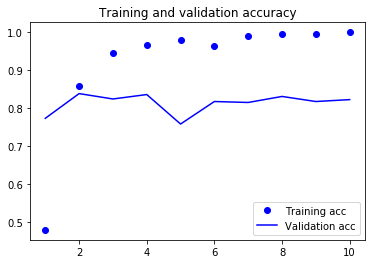

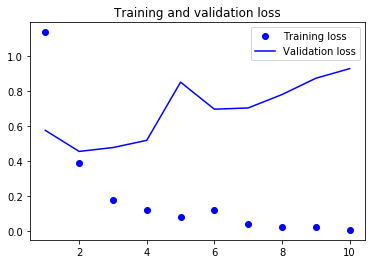

In [242]:
# generate the graph for training and validation accuracy, and training and validation loss
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
# try to predict a new text sentence
txt = ["how to get a credit card"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['Account', 'Transfer', 'CreditCard']
print(pred, labels[np.argmax(pred)])

[[0.79757947 0.09528358 0.10713701]] Account


In [24]:
# serialize model to JSON
model_json = model.to_json()
with open("C:/Users/sumud/Documents/AI/attempt2/final/model-4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("C:/Users/sumud/Documents/AI/attempt2/final/model-4.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))